# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# First analyzing the shape of the two datasets
print("Description of general demographics data")
print("#Rows, #columns: \t\t\t", azdias.shape)
print("Description of Feature Summary data")
print("#Rows, #columns: \t\t\t", feat_info.shape)

Description of general demographics data
#Rows, #columns: 			 (891221, 85)
Description of Feature Summary data
#Rows, #columns: 			 (85, 4)


In [4]:
# Print first few rows of general demographics data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Print first few rows of feature summary data
feat_info.head()

# Reviewing the feature summary table it seems that the missing values are captured by different values across the features

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# Checking the properties
feat_info.info()
# Extract list of missing values and seperate them out
feat_info['missing_items'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
# Check implementation
print(feat_info['missing_items'][59]) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
['-1', 'XX']


In [7]:
# Since there are values as X and XX these need to be converted to proper format (int to int, str to str)
def conver_int_str(x):
  try:
    return int(x)
  except ValueError:
    return x

In [8]:
for i in range(len(feat_info['missing_items'])):
    for j in range(len(feat_info['missing_items'][i])):
        feat_info['missing_items'][i][j]= conver_int_str(feat_info['missing_items'][i][j])

# Check implementation
list1 = feat_info['missing_items'][0] 
print(all(isinstance(n, int) for n in list1))
list1 = feat_info['missing_items'][59] 
print(all(isinstance(n, int) for n in list1))

True
False


In [9]:
#azdias2 = pd.DataFrame()
for i in feat_info['attribute']:
    for j in feat_info['missing_items'][feat_info.index[feat_info['attribute']==i][0]]:
        azdias[i]= azdias[i].replace(j,np.NaN)

# Check implementation
azdias.head()
#print(azdias2.shape)
#print(azdias.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

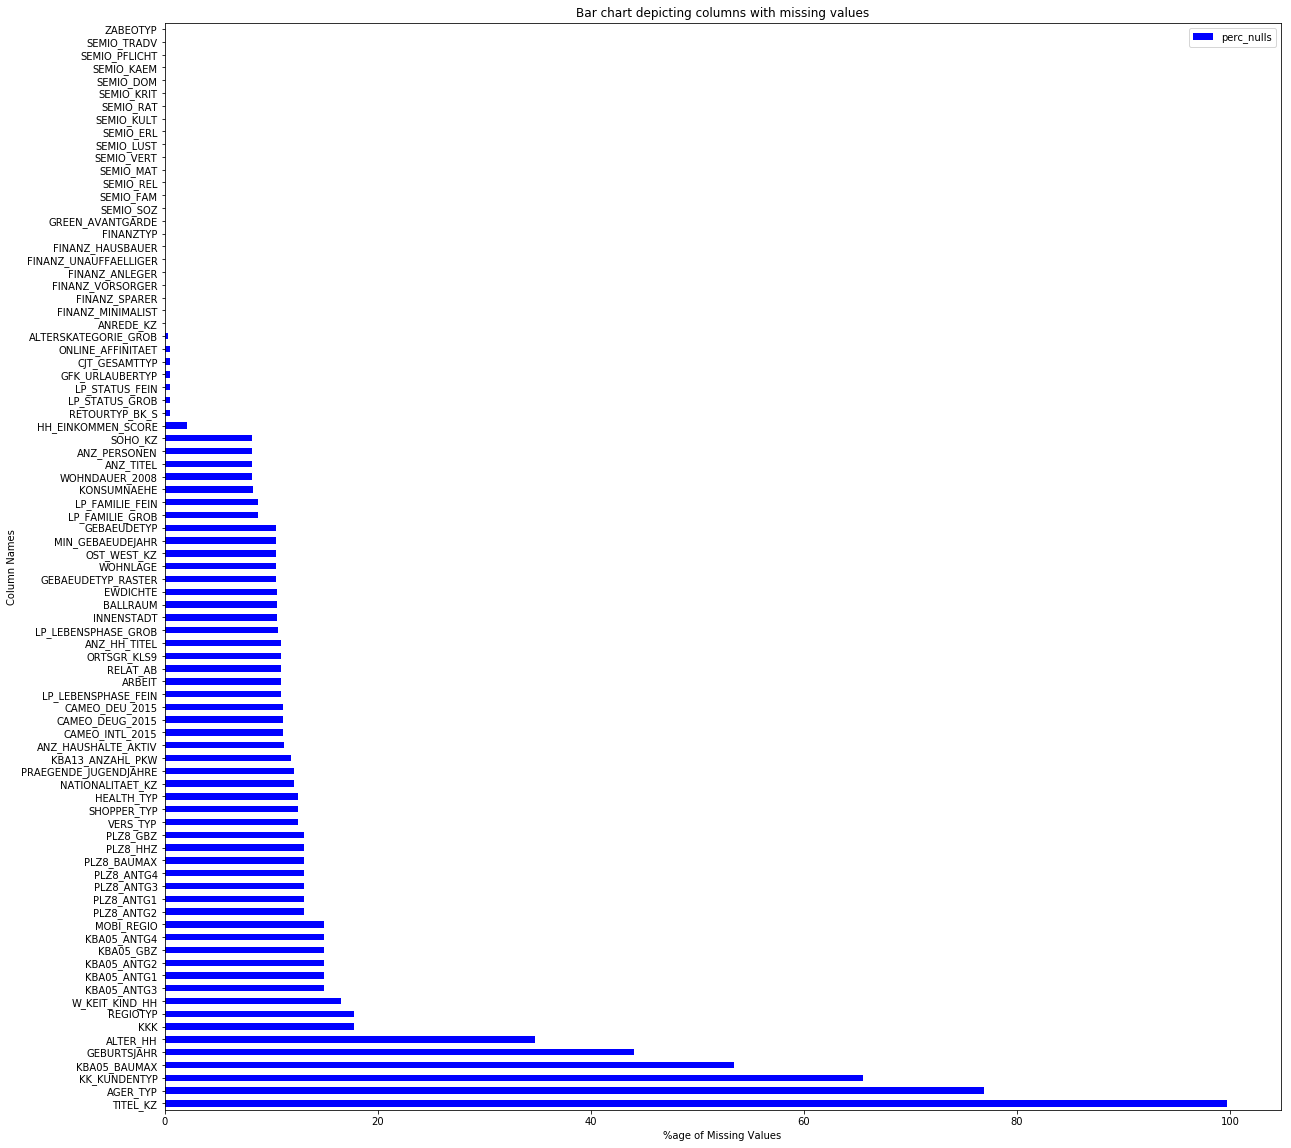

,attribute,perc_nulls
40,TITEL_KZ,99.757636
0,AGER_TYP,76.955435
47,KK_KUNDENTYP,65.596749
64,KBA05_BAUMAX,53.468668
11,GEBURTSJAHR,44.020282


In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_summary = pd.DataFrame(azdias.isnull().sum())
missing_summary_final = (missing_summary [missing_summary  > 0] / azdias.shape[0]*100)
missing_summary_final.reset_index(inplace=True)
missing_summary_final.columns = ['attribute','perc_nulls']
missing_summary_final.sort_values('perc_nulls', ascending=False,inplace=True)
missing_summary_final.plot.barh(x= 'attribute',figsize=(20,20),fontsize=10,color='blue')
plt.xlabel('%age of Missing Values')
plt.ylabel('Column Names')
plt.title('Bar chart depicting columns with missing values')
plt.show()
# Check top 5 columns with missing data
missing_summary_final.head()

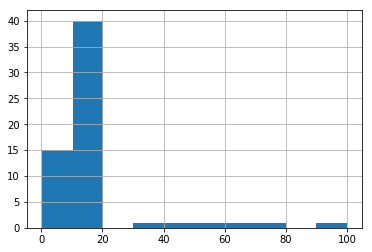

In [11]:
# Investigate patterns in the amount of missing data in each column.
missing_summary_final['perc_nulls'].hist()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Remove columns with more than 34% missing values
threshold = .34
remove_cols = missing_summary_final.loc[missing_summary_final['perc_nulls']>threshold * 100,'attribute']
print("List of features to be removed\n", remove_cols)

azdias_cleaned = azdias.drop(remove_cols, axis=1)
print(azdias_cleaned.shape)

List of features to be removed
 40        TITEL_KZ
0         AGER_TYP
47    KK_KUNDENTYP
64    KBA05_BAUMAX
11     GEBURTSJAHR
43        ALTER_HH
Name: attribute, dtype: object
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

1. There are 6 features (out of the total 85 features) which have more than 30% of missing values and these are excluded from the analysis. Following is a description of these columns
    - TITEL_KZ = Academic title 
    - AGER_TYP = Elderly category
    - KK_KUNDENTYP = Consumer pattern over past 12 months
    - KBA05_BAUMAX = Most common building type within the microcell
    - GEBURTSJAHR = Year of birth
    - ALTER_HH = Birth date of head of household
2. Most of the columns contain less than 20% of missing values. And it seems that most of the features of the for the "Person" level information have non-null values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
mis_row_summary = pd.DataFrame(azdias_cleaned.isna().sum(axis=1)) 
mis_row_final = (mis_row_summary [mis_row_summary  > 0] / azdias_cleaned.shape[1] * 100)
mis_row_final.columns = ['perc_nulls']
print('Total # Rows:', mis_row_final.shape[0])
print('%age Rows with atleast 1 missing feature:', (mis_row_final[mis_row_final['perc_nulls']>0].shape[0]/mis_row_final.shape[0])*100)
mis_row_final.head()

Total # Rows: 891221
%age Rows with atleast 1 missing feature: 30.07245116531141


,perc_nulls
0,54.430380
1,NaN
2,NaN
3,8.860759
4,NaN


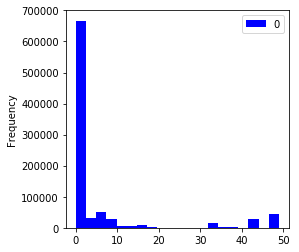

In [14]:
# Histogram of missing value counts
mis_row_summary.plot(kind='hist',bins=20,figsize=(4,4),color='blue');

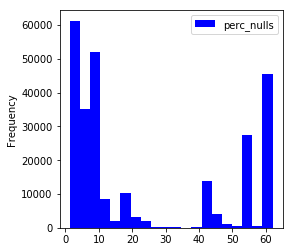

In [15]:
# Histogram plot of percentage missing values in rows
mis_row_final.plot(kind='hist',bins=20,figsize=(4,4),color='blue');

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 10 # missing values threshold

below_threshold  = azdias_cleaned[azdias_cleaned.isnull().sum(axis=1) <= threshold]
above_threshold = azdias_cleaned[azdias_cleaned.isnull().sum(axis=1) > threshold]

print('%age records with missing data greater than threshold', (above_threshold.shape[0]/azdias_cleaned.shape[0])*100  )
print('%age records with missing data less than or equal to threshold', (below_threshold.shape[0]/azdias_cleaned.shape[0])*100 )

%age records with missing data greater than threshold 12.462453196233033
%age records with missing data less than or equal to threshold 87.53754680376696


In [17]:
# Function to compare missing data in a column
def compare_plot (df1, df2, column):
    plt.figure(figsize = (10,10))
    fig, ax =plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0]).set_title(get_df_name(df1))
    sns.countplot(df2[column], ax=ax[1]).set_title(get_df_name(df2))
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return

# Function to get df name
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


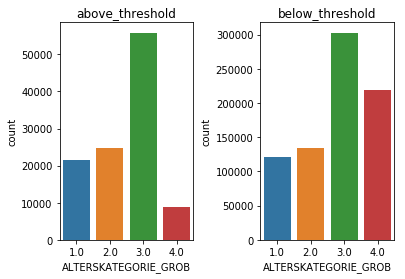

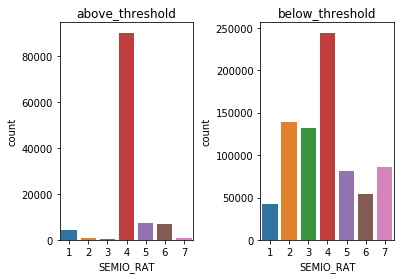

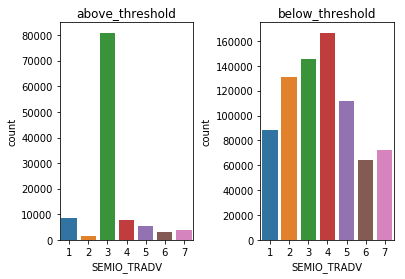

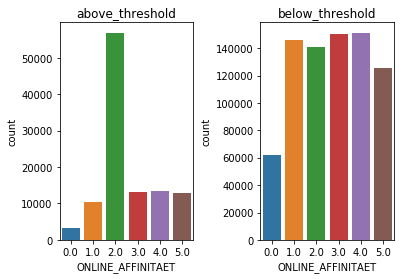

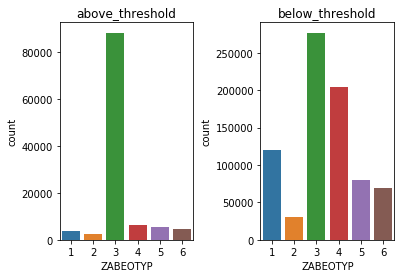

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

test_cols = ['ALTERSKATEGORIE_GROB',  'SEMIO_RAT', 'SEMIO_TRADV', 'ONLINE_AFFINITAET', 'ZABEOTYP']

for cols in test_cols:
    compare_plot (above_threshold, below_threshold, cols)


#### Discussion 1.1.3: Assess Missing Data in Each Row

There are around 30% records (rows) with more than one missing features. And around 10% of the records contain more than 30% of of missing feautures. 
From the comparison plots it does seem that the data with lots of missing values are qualitatively different from data with few or no missing values as the distribution in both the cases is quite different from each other (eg. SEMO_TRADV, SEMO_RAT)
The above threshold piece seems to be sparsely populated with significant skew of values; the below threshold data seems uniformly distributed and hence more suitable for analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?

# Number of Features in Original db
feat_info.groupby('type')['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

In [20]:
# Number of Features in the reduced db with some features removed
select_features = pd.DataFrame(azdias_cleaned.columns).rename(columns={0:'attribute'})
feat_info_new = feat_info.merge(select_features, how='inner', on=['attribute'])
feat_info_new.groupby('type')['attribute'].count()

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

In [21]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_items
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_vars = feat_info_new[feat_info_new['type'] == 'categorical']['attribute'].values
binary = [x for x in cat_vars if azdias_cleaned[x].nunique()==2]
multilevel = [x for x in cat_vars if azdias_cleaned[x].nunique()>2]
azdias_cleaned[cat_vars].nunique()
# Summary of attributes and their corresponding number of levels below

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [23]:
# which one needs to be re-encoded?
for i in cat_vars:
    print(azdias_cleaned[i].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0    

Drop features with more than 10 values as these are too granular for analysis:
GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015'

Re-encode the variable OST_WEST_KZ as it currently has non-numeric values

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

below_threshold["OST_WEST_KZ"]=below_threshold["OST_WEST_KZ"].replace({"W": 1,"O":0})

below_threshold = below_threshold.drop(['CAMEO_DEUG_2015','GFK_URLAUBERTYP','LP_FAMILIE_FEIN'],axis=1)

multilevel.remove('GFK_URLAUBERTYP')
multilevel.remove('LP_FAMILIE_FEIN')
multilevel.remove('CAMEO_DEUG_2015')

# Check implementation
below_threshold.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(780153, 76)

In [25]:
# Check implementation
print(below_threshold['OST_WEST_KZ'].unique())
print(multilevel)

[1 0]
['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015']


In [26]:
# Convert multilevel categorical features into dummy variables
azdias_bth_new = pd.get_dummies(below_threshold, columns = multilevel)

In [27]:
print(azdias_bth_new.shape)

(780153, 162)


#### Discussion 1.2.1: Re-Encode Categorical Features

1. The original database had 21 categorical features and the database created after dropping columns with significant number of missing values had 18 categorical features
2. Features with more than 10 values have been dropped as these are too granular for analysis: 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015'
3. The variable 'OST_WEST_KZ' has been re-encoded as it captured non-numerical values in the original database
4. All the multi-level features (except the ones dropped) have been one hot encoded


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
#Review mixed type variables
feat_mixed = feat_info_new [feat_info_new ['type'] =='mixed']
display (feat_mixed)

azdias_bth_new[['PRAEGENDE_JUGENDJAHRE']].head()

,attribute,information_level,type,missing_or_unknown,missing_items
13,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
20,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
51,WOHNLAGE,building,mixed,[-1],[-1]
54,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
73,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def map_decade (x):
    if x in (1,2):
        return 0
    if x in (3,4):
        return 1
    if x in (5,6,7):
        return 2
    if x in (8,9):
        return 3
    if x in (10,11,12,13):
        return 4
    if x in (14,15):
        return 5
    
def map_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 1
    if x in (1,3,5,8,10,12,14):
        return 0

azdias_bth_new['decade']= azdias_bth_new['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
azdias_bth_new['movement']= azdias_bth_new['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [30]:
# Drop 'PRAEGENDE_JUGENDJAHRE' as it has been re-engineered to two variables
azdias_bth_new.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
# Check implementation
print(azdias_bth_new['decade'].value_counts())
print(azdias_bth_new['movement'].value_counts())

5.0    219439
3.0    171875
4.0    148118
2.0    113126
1.0     73441
0.0     27680
Name: decade, dtype: int64
0.0    581988
1.0    171691
Name: movement, dtype: int64


In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_bth_new[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [32]:
# It seems that CAMEO_INTL_2015 has the first digit unique for Wealth and the second digit unique for Lifestage
azdias_bth_new['wealth'] = azdias_bth_new['CAMEO_INTL_2015'].str.slice(0,1)
azdias_bth_new['life_stage'] = azdias_bth_new['CAMEO_INTL_2015'].str.slice(1,2)

In [33]:
# Drop 'CAMEO_INTL_2015' as it has been re-engineered to two variables
azdias_bth_new.drop('CAMEO_INTL_2015', axis=1, inplace=True)
# Check implementation
print(azdias_bth_new['wealth'].value_counts())
print(azdias_bth_new['life_stage'].value_counts())

5    221854
4    187271
2    184575
1    116706
3     66091
Name: wealth, dtype: int64
1    241777
4    228456
3    115411
5    115187
2     75666
Name: life_stage, dtype: int64


In [34]:
# Investigate "WOHNLAGE" and engineer two new variables.
azdias_bth_new['WOHNLAGE'].value_counts()

3.0    246155
7.0    167130
4.0    134022
2.0     98784
5.0     72899
1.0     43191
8.0     15018
0.0      2954
Name: WOHNLAGE, dtype: int64

In [35]:
def map_rural (x):
    if x in (0,1,2,3,4,5):
        return 0
    if x in (7,8):
        return 1
      
def map_qne (x):
    if x in (0,):
        return 1
    if x in (1,):
        return 2
    if x in (2,):
        return 3
    if x in (3,):
        return 4
    if x in (4,):
        return 5
    if x in (5,):
        return 6
    if x in (7,8):
        return 0

azdias_bth_new['rural']= azdias_bth_new['WOHNLAGE'].apply(map_rural)
azdias_bth_new['qne']= azdias_bth_new['WOHNLAGE'].apply(map_qne)

In [36]:
# Drop 'WOHNLAGE' as it has been re-engineered to two variables
azdias_bth_new.drop('WOHNLAGE', axis=1, inplace=True)
# Check implementation
print(azdias_bth_new['rural'].value_counts())
print(azdias_bth_new['qne'].value_counts())

0    598005
1    182148
Name: rural, dtype: int64
4    246155
0    182148
5    134022
3     98784
6     72899
2     43191
1      2954
Name: qne, dtype: int64


In [37]:
feat_mixed_list = feat_mixed['attribute'].tolist()
feat_mixed_list.remove('PRAEGENDE_JUGENDJAHRE')
feat_mixed_list.remove('CAMEO_INTL_2015')
feat_mixed_list.remove('WOHNLAGE')
feat_mixed_list

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']

In [38]:
azdias_bth_new = azdias_bth_new.drop(feat_mixed_list, axis=1)
print(azdias_bth_new.shape)

(780153, 162)


#### Discussion 1.2.2: Engineer Mixed-Type Features

1. There were 7 mixed features in the dataset out of which one (KBA05_BAUMAX) was already dropped from the analysis as it had a considerable number of missing values
2. Of the remaining 6 features, two of the features - 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' have been re-engineered into two features each (and original features have been dropped). They have been re-engineered to decade/movement and wealth/lifestage respectively
3. One more feature 'WOHNLAGE' has been re-engineered into two - rural (rural/not rural) and quality of neighborhood. This maybe helpful in the analysis
4. Rest of the 3 features ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX') have been removed from the analysis as it seemed that the information captured in them is already captured elsewhere so it keeping these mixed variables would be redundant. Plus, the complexity would be reduced by removing them

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# Checking some df information. All the processing has been taken care of in the previous steps so no addl. steps are reqd. here
print(np.unique(azdias_bth_new.dtypes.values))
print(azdias_bth_new.shape)
azdias_bth_new.head()

[dtype('uint8') dtype('int64') dtype('float64') dtype('O')]
(780153, 162)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,5.0,0.0,5,1,0,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,5.0,1.0,2,4,0,3
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,3.0,0.0,1,2,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,3.0,0.0,4,3,0,4
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1.0,0.0,5,4,1,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df,feat_info=feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Extract list of missing values and seperate them out
    feat_info['missing_items'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
    
    # Since there are values as X and XX these need to be converted to proper format (int to int, str to str)
    for i in range(len(feat_info['missing_items'])):
        for j in range(len(feat_info['missing_items'][i])):
            feat_info['missing_items'][i][j]= conver_int_str(feat_info['missing_items'][i][j])
            
    for i in feat_info['attribute']:
        for j in feat_info['missing_items'][feat_info.index[feat_info['attribute']==i][0]]:
            df[i]= df[i].replace(j,np.NaN)
    
    # remove selected columns and rows, ...
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    missing_summary = pd.DataFrame(df.isnull().sum())
    missing_summary_final = (missing_summary [missing_summary  > 0] / df.shape[0]*100)
    missing_summary_final.reset_index(inplace=True)
    missing_summary_final.columns = ['attribute','perc_nulls']
    
    #threshold = .34
    #remove_cols = missing_summary_final.loc[missing_summary_final['perc_nulls']>threshold * 100,'attribute']
    #Commmenting the above piece out as per feedback
    remove_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_cleaned = df.drop(remove_cols, axis=1)
       
    # How much data is missing in each row of the dataset?
    mis_row_summary = pd.DataFrame(df_cleaned.isna().sum(axis=1)) 
    mis_row_final = (mis_row_summary [mis_row_summary  > 0] / df_cleaned.shape[1] * 100)
    mis_row_final.columns = ['perc_nulls']    
    
    threshold = 10 # missing values threshold
    below_threshold  = df_cleaned[df_cleaned.isnull().sum(axis=1) <= threshold]
    above_threshold = df_cleaned[df_cleaned.isnull().sum(axis=1) > threshold]
    
    # New feat info
    select_features = pd.DataFrame(df_cleaned.columns).rename(columns={0:'attribute'})
    feat_info_new = feat_info.merge(select_features, how='inner', on=['attribute'])
    
    # select, re-encode, and engineer column values.
    
    cat_vars = feat_info_new[feat_info_new['type'] == 'categorical']['attribute'].values
    binary = [x for x in cat_vars if df_cleaned[x].nunique()==2]
    multilevel = [x for x in cat_vars if df_cleaned[x].nunique()>2]
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    below_threshold["OST_WEST_KZ"]=below_threshold["OST_WEST_KZ"].replace({"W": 1,"O":0})
    below_threshold = below_threshold.drop(['CAMEO_DEUG_2015','GFK_URLAUBERTYP','LP_FAMILIE_FEIN'],axis=1)
    multilevel.remove('GFK_URLAUBERTYP')
    multilevel.remove('LP_FAMILIE_FEIN')
    multilevel.remove('CAMEO_DEUG_2015')
    
    # Convert multilevel categorical features into dummy variables
    df_bth_new = pd.get_dummies(below_threshold, columns = multilevel)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_bth_new['decade']= df_bth_new['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df_bth_new['movement']= df_bth_new['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    # Drop 'PRAEGENDE_JUGENDJAHRE' as it has been re-engineered to two variables
    df_bth_new.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Investigate 'CAMEO_INTL_2015' and engineer two new variables.
    df_bth_new['wealth'] = df_bth_new['CAMEO_INTL_2015'].str.slice(0,1)
    df_bth_new['life_stage'] = df_bth_new['CAMEO_INTL_2015'].str.slice(1,2)
    # Drop 'CAMEO_INTL_2015' as it has been re-engineered to two variables
    df_bth_new.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Investigate 'WOHNLAGE' and engineer two new variables.
    df_bth_new['rural']= df_bth_new['WOHNLAGE'].apply(map_rural)
    df_bth_new['qne']= df_bth_new['WOHNLAGE'].apply(map_qne)
    # Drop 'WOHNLAGE' as it has been re-engineered to two variables
    df_bth_new.drop('WOHNLAGE', axis=1, inplace=True)
    
    # Drop additional mixed features
    feat_mixed_list = feat_mixed['attribute'].tolist()
    feat_mixed_list.remove('PRAEGENDE_JUGENDJAHRE')
    feat_mixed_list.remove('CAMEO_INTL_2015')
    feat_mixed_list.remove('WOHNLAGE')
    df_bth_new = df_bth_new.drop(feat_mixed_list, axis=1)
       
    # Return the cleaned dataframe.
    return df_bth_new 

In [41]:
# Check implementation
azdias_final = clean_data(azdias,feat_info)
azdias_final.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(780153, 162)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Check for NaNs
nan_count = azdias_final.isna().sum()
nan_count = pd.DataFrame(nan_count[nan_count!=0]).reset_index()
nan_count.columns = ['attribute', 'num_nans']
nan_count
# Seems there are still some columns with NaNs

,attribute,num_nans
0,ALTERSKATEGORIE_GROB,2625
1,HEALTH_TYP,34524
2,RETOURTYP_BK_S,3834
3,VERS_TYP,34524
4,W_KEIT_KIND_HH,56282
5,ANZ_HAUSHALTE_AKTIV,5740
6,ANZ_HH_TITEL,3233
7,KONSUMNAEHE,51
8,KBA05_ANTG1,24457
9,KBA05_ANTG2,24457


In [43]:
nan_count = nan_count.merge(feat_info_new, on='attribute', how='left')
nan_count = nan_count.sort_values(['num_nans'], ascending = False)
nan_count.reset_index(drop=True);

In [44]:
# Seperating out the variables by type
numeric_vars = nan_count.loc[(nan_count['type'] == 'numeric'),'attribute'].tolist()
ord_or_cat_vars = nan_count.loc[(nan_count['type'] != 'numeric'),'attribute'].tolist()

In [45]:
# For numeric variables having NaNs use median
imputer_1 = Imputer(missing_values=np.nan , strategy='median', axis=0)
azdias_final[numeric_vars] = imputer_1.fit_transform(azdias_final[numeric_vars])

# For other variables - oridnal, categorical and the newly split mixed type features use most frequent for imputing
imputer_2 = Imputer(missing_values=np.nan , strategy = 'most_frequent', axis=0)
azdias_final[ord_or_cat_vars] = imputer_2.fit_transform(azdias_final[ord_or_cat_vars])

In [46]:
# Check if any NaNs are remaining
nan_count = azdias_final.isna().sum()
print(nan_count[nan_count!=0])
azdias_final.shape

Series([], dtype: int64)


(780153, 162)

In [47]:
# Apply feature scaling to the general population demographics data.
std_scaler = StandardScaler()
azdias_scaled = pd.DataFrame(std_scaler.fit_transform(azdias_final), columns = azdias_final.columns)
print(azdias_scaled.shape)
azdias_scaled.head()

(780153, 162)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne
0,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.006277,...,-0.191144,-0.181397,-0.194377,-0.08919,1.105284,-0.531199,1.170995,-1.249732,-0.551899,0.913747
1,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.006277,...,-0.191144,-0.181397,-0.194377,-0.08919,1.105284,1.882535,-0.874275,0.763856,-0.551899,-0.088201
2,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.316158,...,-0.191144,-0.181397,-0.194377,-0.08919,-0.259737,-0.531199,-1.556031,-0.578536,1.811925,-1.591123
3,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.006277,...,-0.191144,-0.181397,-0.194377,-0.08919,-0.259737,-0.531199,0.489238,0.092660,-0.551899,0.412773
4,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.006277,...,-0.191144,-0.181397,-0.194377,-0.08919,-1.624758,-0.531199,1.170995,0.763856,1.811925,-1.591123


### Discussion 2.1: Apply Feature Scaling

1. Using Imputer the NaNs have been imputed in the dataset
    - The NaNs in case of numeric variables have been imputed using median
    - The NaNs in case of all other variable types have been imputed using most frequent
2. All the variables have been scaled using StandardScaler as it is the most commonly used scaling method/ technique

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.

pca = PCA(random_state=38)
azdias_pca = pca.fit_transform(azdias_scaled)

In [49]:
# Investigate the variance accounted for by each principal component.

# Scree-plot from PCA lessons
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

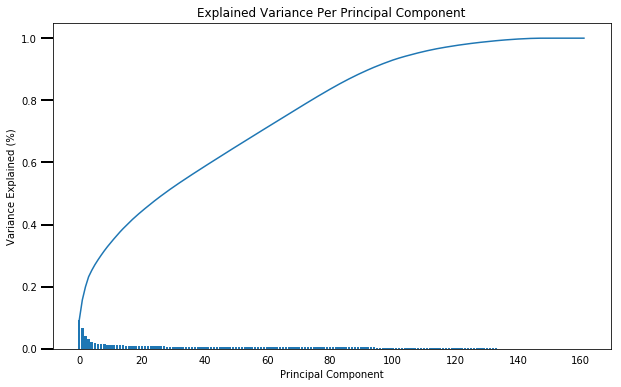

In [50]:
scree_plot(pca)

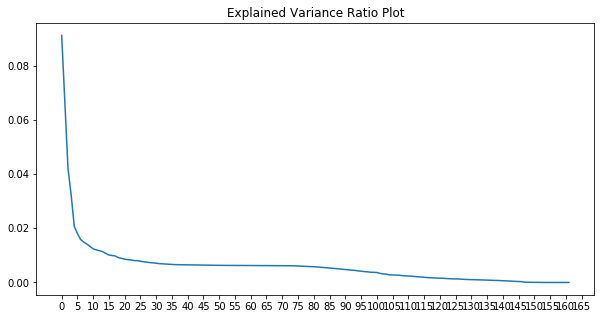

In [51]:
# Plotting explained variance ratio
pca_evr = pca.explained_variance_ratio_
plt.figure(figsize = (10,5))
plt.xticks([i*5 for i in range(100)])
plt.title('Explained Variance Ratio Plot')
plt.plot(pca_evr)

In [52]:
# Testing out with different num component combinations
pca_variance = pca.explained_variance_ratio_.tolist()
print(np.sum(pca_variance[:35]))

0.5478515205156154


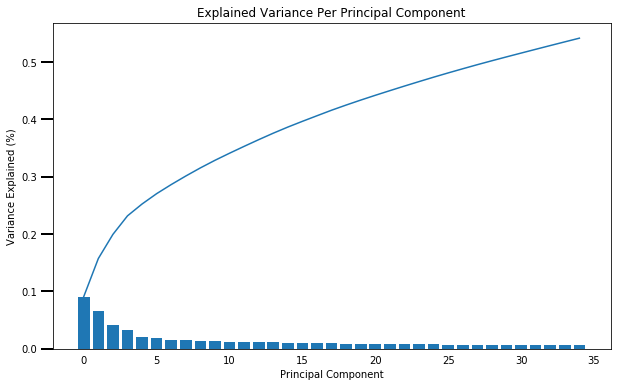

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=35,random_state=38)
azdias_pca = pca.fit_transform(azdias_scaled)
scree_plot(pca)


### Discussion 2.2: Perform Dimensionality Reduction

1. PCA has been applied and all components and the results have been visualized using scree plots
2. Per the analysis, the number of components selected for PCA is 35 as it seems that 35 components explain more than 50% of the variance and at the same time are not a stress computationally

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, i, input_df=azdias_scaled):
    df = pd.DataFrame(pca.components_, columns=list(input_df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    print("Principal Component", (i))
    print('*' * 30)
    print(weights.head(5))
    print('-' * 30)
    print(weights.tail(5))

pca_weights(pca, 0, azdias_scaled)

Principal Component 0
******************************
LP_STATUS_GROB_1.0    0.200433
PLZ8_ANTG3            0.187353
HH_EINKOMMEN_SCORE    0.181866
PLZ8_ANTG4            0.179942
wealth                0.179338
Name: 0, dtype: float64
------------------------------
KBA05_GBZ           -0.183944
KBA05_ANTG1         -0.184657
PLZ8_ANTG1          -0.185836
MOBI_REGIO          -0.194816
FINANZ_MINIMALIST   -0.197221
Name: 0, dtype: float64


In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca, 1, azdias_scaled)

Principal Component 1
******************************
ALTERSKATEGORIE_GROB    0.233541
FINANZ_VORSORGER        0.218716
ZABEOTYP_3              0.201529
SEMIO_ERL               0.185690
SEMIO_LUST              0.162416
Name: 1, dtype: float64
------------------------------
SEMIO_TRADV             -0.209273
FINANZ_UNAUFFAELLIGER   -0.215807
SEMIO_REL               -0.219221
FINANZ_SPARER           -0.225446
decade                  -0.229871
Name: 1, dtype: float64


In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca, 2, azdias_scaled)

Principal Component 2
******************************
SEMIO_VERT     0.317939
SEMIO_SOZ      0.254631
SEMIO_FAM      0.254375
SEMIO_KULT     0.244335
FINANZTYP_5    0.141438
Name: 2, dtype: float64
------------------------------
SEMIO_ERL    -0.201810
SEMIO_KRIT   -0.262556
SEMIO_DOM    -0.276150
SEMIO_KAEM   -0.309171
ANREDE_KZ    -0.341415
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

1. The Principal Component 0, seems to capture details related to personal income/ wealth/ social status/ spending as the top 5 features such as LP_STATUS_GROB - Social Status, HH_EINKOMMEN_SCORE - Net Household Income, PLZ8_ANTG1 - Number of Houses in a specific region, FINANZ_MINIMALIST -  Low Financial Interest. Hence, PC 0 seems to be somehow related to wealth/ affluence and the population density in an area 
2. The Principal Component 1, seems to capture details related to the age and personal/ financial topology. The Top 5 features here are such as - ALTERSKATEGORIE_GROB- Estimated age, decade - decade of individual's youth, SEMIO_LUST- sensual minded, SEMIO_TRADV - traditional minded, FINIANZ_VORSORGER: be prepared financically. This would make sense as one would except older people to be more traditional, relgious and money saving as compared to younger people who'd be more event/ sensual oriented
3. The Principal Component 2, seems to capture details related to personality traits of an individual. The Top 5 features here are such as SEMIO_VERT - dreamful personality topology, ANREDE_KZ - gender, SEMIO_SOZ - socially minded personality typology, SEMIO_KAEM - combative perosnality typology. The gender category, combative and dominant attitude are in sync and are contrasted by dreamful, socially minded, family oriented traits on the other hand

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def get_kmeans_score(data, center):
    
    #instantiate 
    kmeans = MiniBatchKMeans(n_clusters=center)

    # fit the model 
    model = kmeans.fit(data)
    
    # obtain score
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,35,1))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

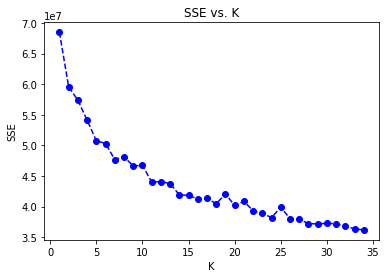

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot SSE vs. K to help choose number of clusters
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [59]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(10, random_state=38)
pop_clusters = kmeans.fit_predict(azdias_pca)

In [60]:
# Check implementation
print(list(set(pop_clusters)))
centers = kmeans.cluster_centers_
centers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


array([[-1.53026542e+00, -4.84672779e+00,  2.38839487e+00,
        -6.69300065e-01, -5.44519518e-01, -3.11889218e-01,
         3.86238741e-01, -1.63349051e-01,  6.09642557e-03,
        -4.54244332e-01, -5.04207177e-01, -3.11765316e-01,
         1.66717461e-01,  2.46095706e-01,  2.87958898e-01,
         3.83982231e-02, -6.67562447e-02,  1.96943936e-01,
        -3.03033681e-01,  2.90138800e-01, -3.86138900e-02,
         9.71129344e-02, -2.14390617e-01,  1.94305641e-01,
        -5.97861254e-02,  4.48381620e-01,  8.42051369e-03,
        -1.68713463e-01,  1.08323329e-01,  1.58760204e-01,
         5.01003179e-02,  1.93777682e-02,  1.25789793e-01,
         4.41191628e-02,  5.15460920e-04],
       [-1.91684004e+00,  2.04418557e+00, -1.46632898e+00,
        -1.58950345e+00, -2.26314204e+00, -1.24238428e-01,
         1.37751948e+00, -1.98214879e-01, -6.05062454e-01,
        -5.72281731e-01,  4.94288569e-01, -2.36355359e-01,
        -1.71909440e-01,  2.95868773e-01,  4.57892466e-01,
        -8.15

### Discussion 3.1: Apply Clustering to General Population

As the KMeans algorithm was taking a considerable amount of time to converge, for the purpose of choosing the number of cluster centers, MiniBatchKMeans was used. In mini-batch k-means the most computationally costly step is conducted on only a random sample of observations as opposed to all observations. This approach can significantly reduce the time required for the algorithm to find convergence (i.e. fit the data) with only a small cost in quality. (Ref: https://chrisalbon.com/machine_learning/clustering/minibatch_k-means_clustering/)

The number of clusters have been chosen as 10 since as per the SSE vs. K plot around that point the rate of change of slope seems to decrease

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter = ';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned= clean_data(customers, feat_info)
print(customers_cleaned.shape)
customers_cleaned.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(139068, 161)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,1.0,1.0,1,3,1,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,1.0,1.0,3,4,0,3
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0.0,0.0,2,4,1,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,3.0,0.0,4,1,0,4
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,1.0,1.0,3,4,0,2


In [63]:
# Check for column consistency in azdias and customers cleaned dataset
# It seems that one less column was processed in the customers cleaned dataset as compared to the azdias cleaned dataset
azdias_final.columns.difference(customers_cleaned.columns)

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [64]:
# It seems that the original customer dataset has no value 5 for the feature GEBAEUDETYP 
# which is why GEBAEUDETY_P5.0 didn't get generated
# Adding dummy values for this variable as 0
customers_cleaned['GEBAEUDETYP_5.0'] = np.zeros(customers_cleaned.shape[0])

In [65]:
# Check for NaNs
nan_count_1 = customers_cleaned.isna().sum()
nan_count_1 = pd.DataFrame(nan_count_1[nan_count_1!=0]).reset_index()
nan_count_1.columns = ['attribute', 'num_nans']
nan_count_1

,attribute,num_nans
0,ALTERSKATEGORIE_GROB,212
1,HEALTH_TYP,2111
2,RETOURTYP_BK_S,2736
3,VERS_TYP,2111
4,W_KEIT_KIND_HH,7503
5,ANZ_HAUSHALTE_AKTIV,2212
6,ANZ_HH_TITEL,1988
7,KONSUMNAEHE,5
8,KBA05_ANTG1,3875
9,KBA05_ANTG2,3875


In [66]:
# Bringing in type information in nan counts
nan_count_1 = nan_count_1.merge(feat_info_new, on='attribute', how='left')
nan_count_1 = nan_count_1.sort_values(['num_nans'], ascending = False)
nan_count_1.reset_index(drop=True);

In [67]:
# Seperating out the variables by type
numeric_vars_1 = nan_count_1.loc[(nan_count_1['type'] == 'numeric'),'attribute'].tolist()
ord_or_cat_vars_1 = nan_count_1.loc[(nan_count_1['type'] != 'numeric'),'attribute'].tolist()
ord_or_cat_vars_1.append('GEBAEUDETYP_RASTER')
# Append the above feature to make it consistent with Azdias; the above feature had NaNs in Azdias but not in Customer dataset
# This caused some problems in the imputation step; hence, the workaround
# Adding this feature won't affect anything since it doesn't have NaNs

In [68]:
# For numeric variables having NaNs use median (use previously used imputer objects)
customers_cleaned[numeric_vars_1] = imputer_1.transform(customers_cleaned[numeric_vars_1])

# For other variables - oridnal, categorical and the newly split mixed type features use most frequent for 
# (use previously used imputer objects)
customers_cleaned[ord_or_cat_vars_1] = imputer_2.transform(customers_cleaned[ord_or_cat_vars_1])

In [69]:
# Check if any NaNs are remaining
nan_count_1 = customers_cleaned.isna().sum()
print(nan_count_1[nan_count_1!=0])
customers_cleaned.shape

Series([], dtype: int64)


(139068, 162)

In [70]:
# Apply feature scaling (use previously used scaler objects)
customers_scaled = pd.DataFrame(std_scaler.transform(customers_cleaned), columns = customers_cleaned.columns)
print(customers_scaled.shape)
customers_scaled.head()

(139068, 162)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne,GEBAEUDETYP_5.0
0,1.180959,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.817895,1.882535,-1.638593,...,-0.191144,-0.181397,-0.194377,11.212044,-1.624758,1.882535,-0.192518,-1.249732,-0.551899,-1.591123
1,1.180959,0.958395,1.414618,-1.151087,1.133828,-1.247812,0.980071,0.611953,1.882535,-0.316158,...,-0.191144,-0.181397,-0.194377,11.212044,-1.624758,6.710001,0.489238,-1.920928,6.539573,-1.591123
2,1.180959,-1.043411,1.414618,-1.151087,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.316158,...,-0.191144,-0.181397,-0.194377,-0.089190,-2.307269,4.296268,0.489238,-1.249732,-0.551899,-1.591123
3,0.198089,-1.043411,-0.036761,-1.151087,0.407468,0.788502,1.697599,-0.817895,-0.531199,1.006277,...,-0.191144,-0.181397,-0.194377,33.814511,-2.307269,9.123735,-1.556031,-1.920928,8.903398,-1.591123
4,0.198089,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.102971,1.882535,1.006277,...,-0.191144,-0.181397,-0.194377,11.212044,-1.624758,6.710001,0.489238,-1.920928,4.175749,-1.591123


In [71]:
# Apply the previously fit PCA on customer data
customers_pca = pca.transform(customers_scaled)
print(customers_pca.shape)
pd.DataFrame(customers_pca).head()

(139068, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-5.890840,2.545380,3.825956,1.833711,-2.648997,-0.686350,0.248191,2.885596,3.585991,-1.121500,...,0.262538,2.347137,1.680072,0.175821,-1.924576,1.518857,-0.379418,-0.308430,1.084622,0.702547
1,-3.551198,5.124652,-0.805116,2.708213,-2.233026,0.033883,-1.827427,-1.681849,2.750183,0.371559,...,-0.481853,3.563993,-4.221107,0.454223,-2.033810,6.429686,-0.258802,-2.896678,-7.296147,1.368623
2,40.342848,46.623705,27.380346,35.294043,-87.047280,256.752754,-80.790877,-20.139840,158.310557,-58.879111,...,-24.232934,146.832620,137.272995,2.192771,-61.578684,344.252012,-264.920417,1.658198,201.843019,27.098460
3,-0.896782,0.322499,1.903355,0.644112,-1.414502,4.336535,0.644788,1.754448,3.674190,-3.022832,...,-2.367878,3.817735,2.921913,-3.370499,-1.391827,5.503527,0.504594,-0.668158,5.637168,1.505354
4,-3.655702,1.453530,3.560303,3.034388,-2.398308,3.879567,-0.735522,1.664781,-0.533898,1.750808,...,0.161101,1.891235,-0.772998,-0.609275,-2.502092,0.602199,0.664760,-0.856478,-1.231951,1.033145


In [72]:
# Apply the previously fit KMeans on customer data
cust_clusters = kmeans.predict(customers_pca)
print(len(cust_clusters))
set(cust_clusters)

139068


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Defining function to get count rollups
def db_prop (df1):
    df_cluster = pd.DataFrame(df1, columns=['clusters'])
    df_cluster['count'] = 1
    df_rollup = pd.DataFrame(df_cluster.groupby(['clusters'])['count'].sum()).reset_index()
    #df_rollup['prop'] = df_rollup['count']/df_rollup['count'].sum()
    
    return df_rollup

azdias_prop =  db_prop(pop_clusters)
customer_prop = db_prop(cust_clusters)

In [74]:
# Add a new cluster -1 to capture the removed customer and population data respectively
pop_mis_count =  len(azdias)-len(azdias_bth_new)
cust_mis_count = len(customers)-len(customers_cleaned)
pop_missing= [[-1,pop_mis_count]]
pop_missing = pd.DataFrame(pop_missing, columns = ['clusters', 'count']) 
cust_missing= [[-1,cust_mis_count]]
cust_missing = pd.DataFrame(cust_missing, columns = ['clusters', 'count']) 

# Append into original cluster dbs
azdias_prop = pop_missing.append(azdias_prop).reset_index(drop=True)
customer_prop = cust_missing.append(customer_prop).reset_index(drop=True)

,clusters,count,prop,source
0,-1,111068,0.124625,azdias
1,0,55222,0.061962,azdias
2,1,61064,0.068517,azdias
3,2,90376,0.101407,azdias
4,3,102358,0.114851,azdias
5,4,69048,0.077476,azdias
6,5,111094,0.124654,azdias
7,6,64218,0.072056,azdias
8,7,93759,0.105203,azdias
9,8,98533,0.110560,azdias


,clusters,count,prop,source
0,-1,52584,0.274372,customer
1,0,1663,0.008677,customer
2,1,17979,0.093811,customer
3,2,7789,0.040641,customer
4,3,9940,0.051865,customer
5,4,1369,0.007143,customer
6,5,26748,0.139565,customer
7,6,401,0.002092,customer
8,7,633,0.003303,customer
9,8,55097,0.287485,customer


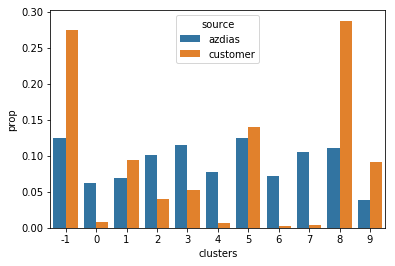

In [75]:
# Get proportions for azdias and customer clusters
azdias_prop['prop'] = azdias_prop['count']/azdias_prop['count'].sum()
azdias_prop['source']='azdias'
customer_prop['prop'] = customer_prop['count']/customer_prop['count'].sum()
customer_prop['source']='customer'
display(azdias_prop)
display(customer_prop)
combined_prop = azdias_prop.append(customer_prop)

# Plot the proportions
sns.barplot(x='clusters', y='prop', hue='source', data=combined_prop)

In [76]:
# Defining function for applying inverse transform
def inv_transform(k,pca,customers_pca,cust_clusters,customers_scaled):
    df = std_scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(cust_clusters==k)])).round()
    df1 = pd.DataFrame(data=df,index=np.array(range(0, df.shape[0])),columns=customers_scaled.columns)
    return df1

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 8 seems to be highly overrepresented in the customer datset as compared to general population
data_clust_8 = inv_transform(8,pca,customers_pca,cust_clusters,customers_scaled)
data_clust_8.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne,GEBAEUDETYP_5.0
0,5.0,1.0,5.0,1.0,5.0,0.0,2.0,3.0,1.0,1.0,...,-0.0,-0.0,0.0,0.0,2.0,1.0,3.0,3.0,0.0,2.0
1,4.0,2.0,5.0,0.0,5.0,1.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,1.0,2.0
2,4.0,1.0,5.0,0.0,6.0,1.0,2.0,3.0,1.0,1.0,...,0.0,-0.0,-0.0,0.0,1.0,1.0,2.0,3.0,0.0,4.0
3,5.0,1.0,5.0,0.0,5.0,1.0,2.0,3.0,1.0,1.0,...,-0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,-1.0
4,4.0,1.0,5.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,...,-0.0,-0.0,0.0,1.0,3.0,1.0,4.0,5.0,1.0,-0.0
5,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,1.0,-2.0
6,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,-0.0,-0.0,0.0,0.0,2.0,1.0,3.0,5.0,1.0,0.0
7,4.0,1.0,6.0,0.0,5.0,0.0,1.0,3.0,1.0,0.0,...,0.0,0.0,-0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0
8,5.0,1.0,4.0,3.0,2.0,2.0,5.0,2.0,1.0,-0.0,...,-0.0,-0.0,0.0,1.0,4.0,1.0,5.0,8.0,0.0,2.0
9,5.0,1.0,5.0,2.0,3.0,1.0,4.0,2.0,1.0,-0.0,...,-0.0,-0.0,0.0,1.0,3.0,1.0,5.0,6.0,0.0,3.0


In [78]:
# Checking component weights for cluster center 8
Comp_Wts_8 = pd.Series(kmeans.cluster_centers_[8])
Comp_Wts_8.sort_values(ascending=False).head(3)

3     3.534652
8     1.101293
10    1.013474
dtype: float64

In [79]:
# Component 3 is the most prominent in cluster 8 (Note that current PC convention is 0 onwards)
pca_weights(pca, 3)

Principal Component 3
******************************
movement               0.316603
GREEN_AVANTGARDE       0.316603
LP_STATUS_GROB_5.0     0.269143
LP_STATUS_FEIN_10.0    0.269143
ORTSGR_KLS9            0.195523
Name: 3, dtype: float64
------------------------------
KKK                  -0.163217
LP_STATUS_FEIN_9.0   -0.176139
HH_EINKOMMEN_SCORE   -0.180532
LP_STATUS_GROB_4.0   -0.181250
rural                -0.198197
Name: 3, dtype: float64


In [80]:
# Component 8 is the second most prominent in cluster 8
pca_weights(pca, 8)

Principal Component 8
******************************
KBA05_ANTG4            0.262178
ANZ_HAUSHALTE_AKTIV    0.224568
LP_STATUS_FEIN_10.0    0.200354
LP_STATUS_GROB_5.0     0.200354
LP_STATUS_FEIN_2.0     0.194334
Name: 8, dtype: float64
------------------------------
SHOPPER_TYP_2.0      -0.132081
PLZ8_ANTG2           -0.195011
LP_STATUS_GROB_2.0   -0.227025
LP_STATUS_FEIN_3.0   -0.256999
KBA05_ANTG2          -0.267469
Name: 8, dtype: float64


In [81]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 6 and Cluster 7 seems to be underepresented in the customer datset as compared to general population
# Checking cluster 6
data_clust_6 = inv_transform(6,pca,customers_pca,cust_clusters,customers_scaled)
data_clust_6.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne,GEBAEUDETYP_5.0
0,3.0,1.0,3.0,2.0,3.0,2.0,4.0,5.0,1.0,0.0,...,-0.0,-0.0,0.0,1.0,3.0,1.0,7.0,6.0,0.0,4.0
1,3.0,1.0,2.0,3.0,2.0,3.0,3.0,6.0,1.0,0.0,...,0.0,-0.0,-0.0,1.0,4.0,1.0,6.0,9.0,1.0,2.0
2,4.0,1.0,3.0,3.0,2.0,2.0,4.0,5.0,1.0,-0.0,...,-0.0,-0.0,-0.0,1.0,4.0,1.0,7.0,8.0,0.0,2.0
3,3.0,1.0,1.0,4.0,2.0,3.0,5.0,5.0,0.0,0.0,...,-0.0,-0.0,0.0,1.0,5.0,0.0,5.0,8.0,-0.0,4.0
4,3.0,1.0,1.0,4.0,2.0,4.0,5.0,6.0,0.0,-0.0,...,-0.0,-0.0,0.0,1.0,4.0,0.0,7.0,8.0,0.0,4.0
5,4.0,1.0,2.0,3.0,1.0,2.0,4.0,4.0,1.0,-1.0,...,-0.0,-0.0,0.0,1.0,4.0,1.0,6.0,7.0,1.0,1.0
6,4.0,1.0,2.0,3.0,2.0,3.0,5.0,4.0,0.0,0.0,...,-0.0,-0.0,0.0,1.0,4.0,0.0,6.0,8.0,0.0,4.0
7,3.0,1.0,2.0,4.0,2.0,3.0,4.0,5.0,1.0,1.0,...,-0.0,-0.0,0.0,1.0,5.0,1.0,6.0,7.0,0.0,2.0
8,3.0,1.0,2.0,3.0,1.0,3.0,5.0,7.0,1.0,-1.0,...,-0.0,-0.0,0.0,1.0,4.0,1.0,7.0,6.0,1.0,2.0
9,3.0,1.0,3.0,2.0,2.0,2.0,4.0,5.0,1.0,-0.0,...,0.0,-0.0,0.0,1.0,3.0,1.0,6.0,7.0,0.0,3.0


In [82]:
# Checking component weights for cluster center 6
Comp_Wts_6 = pd.Series(kmeans.cluster_centers_[6])
Comp_Wts_6.sort_values(ascending=False).head(3)

0    4.707809
2    2.679126
8    0.643456
dtype: float64

In [83]:
# Component 0 is the most prominent in cluster 6
pca_weights(pca, 0)

Principal Component 0
******************************
LP_STATUS_GROB_1.0    0.200433
PLZ8_ANTG3            0.187353
HH_EINKOMMEN_SCORE    0.181866
PLZ8_ANTG4            0.179942
wealth                0.179338
Name: 0, dtype: float64
------------------------------
KBA05_GBZ           -0.183944
KBA05_ANTG1         -0.184657
PLZ8_ANTG1          -0.185836
MOBI_REGIO          -0.194816
FINANZ_MINIMALIST   -0.197221
Name: 0, dtype: float64


In [84]:
# Component 2 is the second most prominent in cluster 6
pca_weights(pca, 2)

Principal Component 2
******************************
SEMIO_VERT     0.317939
SEMIO_SOZ      0.254631
SEMIO_FAM      0.254375
SEMIO_KULT     0.244335
FINANZTYP_5    0.141438
Name: 2, dtype: float64
------------------------------
SEMIO_ERL    -0.201810
SEMIO_KRIT   -0.262556
SEMIO_DOM    -0.276150
SEMIO_KAEM   -0.309171
ANREDE_KZ    -0.341415
Name: 2, dtype: float64


In [85]:
# Cluster 6 and Cluster 7 seems to be underepresented in the customer datset as compared to general population
# Checking cluster 7
data_clust_7 = inv_transform(7,pca,customers_pca,cust_clusters,customers_scaled)
data_clust_7.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,rural,qne,GEBAEUDETYP_5.0
0,3.0,2.0,1.0,3.0,2.0,4.0,3.0,6.0,1.0,0.0,...,-0.0,-0.0,0.0,1.0,4.0,1.0,5.0,4.0,1.0,2.0
1,3.0,2.0,1.0,4.0,2.0,4.0,4.0,6.0,1.0,0.0,...,-0.0,-0.0,-0.0,1.0,4.0,1.0,6.0,8.0,-0.0,4.0
2,2.0,2.0,4.0,1.0,4.0,3.0,1.0,4.0,1.0,1.0,...,0.0,0.0,-0.0,0.0,2.0,1.0,6.0,2.0,1.0,2.0
3,3.0,2.0,2.0,3.0,2.0,4.0,3.0,5.0,0.0,1.0,...,-0.0,-0.0,0.0,1.0,4.0,0.0,7.0,7.0,0.0,3.0
4,3.0,2.0,1.0,3.0,2.0,3.0,5.0,5.0,1.0,1.0,...,-0.0,-0.0,-0.0,1.0,4.0,1.0,6.0,6.0,0.0,3.0
5,3.0,2.0,1.0,3.0,2.0,3.0,4.0,6.0,1.0,-1.0,...,-0.0,-0.0,0.0,1.0,4.0,1.0,7.0,6.0,0.0,3.0
6,3.0,2.0,1.0,4.0,2.0,4.0,5.0,6.0,1.0,1.0,...,-0.0,-0.0,0.0,1.0,5.0,1.0,7.0,8.0,0.0,3.0
7,3.0,2.0,2.0,3.0,1.0,3.0,3.0,6.0,1.0,-0.0,...,0.0,-0.0,0.0,1.0,4.0,1.0,7.0,6.0,1.0,2.0
8,3.0,2.0,2.0,2.0,3.0,2.0,3.0,5.0,1.0,1.0,...,-0.0,-0.0,0.0,1.0,3.0,1.0,6.0,6.0,1.0,1.0
9,3.0,2.0,1.0,4.0,1.0,3.0,5.0,5.0,1.0,1.0,...,-0.0,-0.0,0.0,1.0,5.0,1.0,6.0,9.0,-0.0,4.0


In [86]:
# Checking component weights for cluster center 7
Comp_Wts_7 = pd.Series(kmeans.cluster_centers_[7])
Comp_Wts_7.sort_values(ascending=False).head(3)

0    4.963854
3    0.780481
9    0.543878
dtype: float64

In [87]:
# Component 1 is the most prominent in cluster 7
pca_weights(pca, 0)

Principal Component 0
******************************
LP_STATUS_GROB_1.0    0.200433
PLZ8_ANTG3            0.187353
HH_EINKOMMEN_SCORE    0.181866
PLZ8_ANTG4            0.179942
wealth                0.179338
Name: 0, dtype: float64
------------------------------
KBA05_GBZ           -0.183944
KBA05_ANTG1         -0.184657
PLZ8_ANTG1          -0.185836
MOBI_REGIO          -0.194816
FINANZ_MINIMALIST   -0.197221
Name: 0, dtype: float64


In [88]:
# Component 3 is the second most prominent in cluster 7
pca_weights(pca, 3)

Principal Component 3
******************************
movement               0.316603
GREEN_AVANTGARDE       0.316603
LP_STATUS_GROB_5.0     0.269143
LP_STATUS_FEIN_10.0    0.269143
ORTSGR_KLS9            0.195523
Name: 3, dtype: float64
------------------------------
KKK                  -0.163217
LP_STATUS_FEIN_9.0   -0.176139
HH_EINKOMMEN_SCORE   -0.180532
LP_STATUS_GROB_4.0   -0.181250
rural                -0.198197
Name: 3, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

1. For atleast 4 clusters (1,2,3,5) the proportion distribution of general population seems to be consistent with the customers dataset. However, some clusters such as 8,6 and 7 seem to be inconsistent in terms of proportion across the two datasets
2. The Cluster -1 which captures the set of population/ customer with too many missing information indicates that there are comparitvely more such folks in the customer dataset as compared to population dataset
3. Cluster 8 represents a set of population that are relatively popular with the mail order company
    - Cluster 8 Characteristics
        - Top earners commanding a high socio-economic status (highest values of LP_STATUS_FEIN and LP_STATUS_GROB)
        - People who are memebrs of the green avantgrade- member in environmental sustainability as part of youth and also of   other avantgrade movements
        - Not living in rural neighbourhoods
        
4. Cluster 6 and 7 represent the sets of population with relatively unpopular with the mail order company
    - Cluster 6 and 7 Characteristics
        - Low income earners, not affluent (low value of LP_STATUS_GROB and high value of HH_EINKOMMEN_SCORE)
        - Low financial interest and high movement pattern
    - Note that, cluster characteristics have been concluded on the basis of only the most promninent component since the gap between most importan and second most important component was considerably high. However, it is worth noting that the component for both the underrepresented sets was the same indicating some amount of similarities in the population in which the company is relatively unpopular 

    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.